In [1]:
from IPython.display import HTML, Image
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# CitiBike

### Main Business Question
- How to manage the supply and demand of citibikes so that there are always **at least 3 bikes available and 3 docks free** at anytime at a station or a station close by (i.e. within 16 feet)?


#### Sub-questions
- When and where are there deficiencies in supply & demand?
    - At the neighboorhood level (i.e. stations within 16 feet)?
    - At the station level?
- Which stations should be prioritized knowing that there are no other station within 16 feet?
- How can we prevent these deficiencies? 
    - At the neighboorhood level (i.e. stations within 16 feet)?
    - At the station level?

### Methodology (Data Collection, Validation & Cleaning)

To be filled out by Gros (ETL process, etc)

### Exploratory Data Analysis


#### SET UP

In [2]:
import numpy as np

# visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# date
import datetime as dt

# distance between points
import geopy.distance

In [3]:
def calculate_distance_in_feet(origin, destination):
    '''
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_feet : float
    '''
    
    return geopy.distance.distance(origin, destination).feet

In [4]:
def day_of_week(df, date_col):
    '''
    Parameters
    ----------
    df : name of dataframe
    date_col : string
        name of column with dates in date format

    Returns
    -------
    day of week : string
    weekday: boolean
    '''
    # day name
    df['day_of_week'] = df[date_col].dt.day_name() 

    # whether or not it is a weekday
    df = df.assign(weekday=np.where(df[date_col].dt.day_name().isin(['Saturday', 'Sunday']), 0, 1))
    
    return df

In [5]:
df = pd.read_csv('availability.csv', parse_dates=['time_interval'])
df.head()

,station_id,station_name,latitude,longitude,zip,borough,hood,available_bikes,available_docks,time_interval,created_at,station_status
0,72,W 52 St & 11 Ave,40.767272,-73.993929,10019,Manhattan,Hell's Kitchen,4,49,2019-05-02 01:30:00,2019-05-04 03:46:05,In Service
1,72,W 52 St & 11 Ave,40.767272,-73.993929,10019,Manhattan,Hell's Kitchen,4,49,2019-05-02 01:45:00,2019-05-04 03:46:05,In Service
2,72,W 52 St & 11 Ave,40.767272,-73.993929,10019,Manhattan,Hell's Kitchen,4,49,2019-05-02 02:00:00,2019-05-04 03:46:05,In Service
3,72,W 52 St & 11 Ave,40.767272,-73.993929,10019,Manhattan,Hell's Kitchen,4,49,2019-05-02 02:15:00,2019-05-04 03:46:05,In Service
4,72,W 52 St & 11 Ave,40.767272,-73.993929,10019,Manhattan,Hell's Kitchen,4,49,2019-05-02 02:30:00,2019-05-04 03:46:05,In Service


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265559 entries, 0 to 265558
Data columns (total 12 columns):
station_id         265559 non-null int64
station_name       265559 non-null object
latitude           265559 non-null float64
longitude          265559 non-null float64
zip                265559 non-null int64
borough            265559 non-null object
hood               265559 non-null object
available_bikes    265559 non-null int64
available_docks    265559 non-null int64
time_interval      265559 non-null datetime64[ns]
created_at         265559 non-null object
station_status     265559 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 24.3+ MB


In [7]:
# add day of week and whether it is a weekday
df = day_of_week(df, 'time_interval')

# extract hour of day
df['hour_of_day'] = df['time_interval'].dt.round('H').dt.hour

#### ANALYSIS
#### When and where are there deficiencies in supply & demand?
We define deficiency when bikes or docks availability is < 3

##### At the neighboorhood level (i.e. stations within 16 feet)?


In [8]:
# create dictionary for each station with the other stations within 16 feet

In [9]:
# only select stations that had < 3 bikes at some point during the day
min_bikes_df = (df.groupby(['station_name', 'hour_of_day'])['available_bikes']
                .mean() # take mean across hour of day and station
                .reset_index()
                .groupby('station_name')['available_bikes']
                .min() # take min by station
                .reset_index()
               )

stations_2_bikes_or_less = min_bikes_df[min_bikes_df['available_bikes'] <= 2]['station_name'].tolist()

# # reduce dataframe to these stations
# df_reduced = df.query('station_name == @stations_2_bikes_or_less')

In [10]:
df_pivot = (df.query('borough == "Manhattan" & station_status == "In Service" & station_name in @stations_2_bikes_or_less')
            .pivot_table(values='available_bikes', index='hood', columns=['hour_of_day'], aggfunc='mean'))

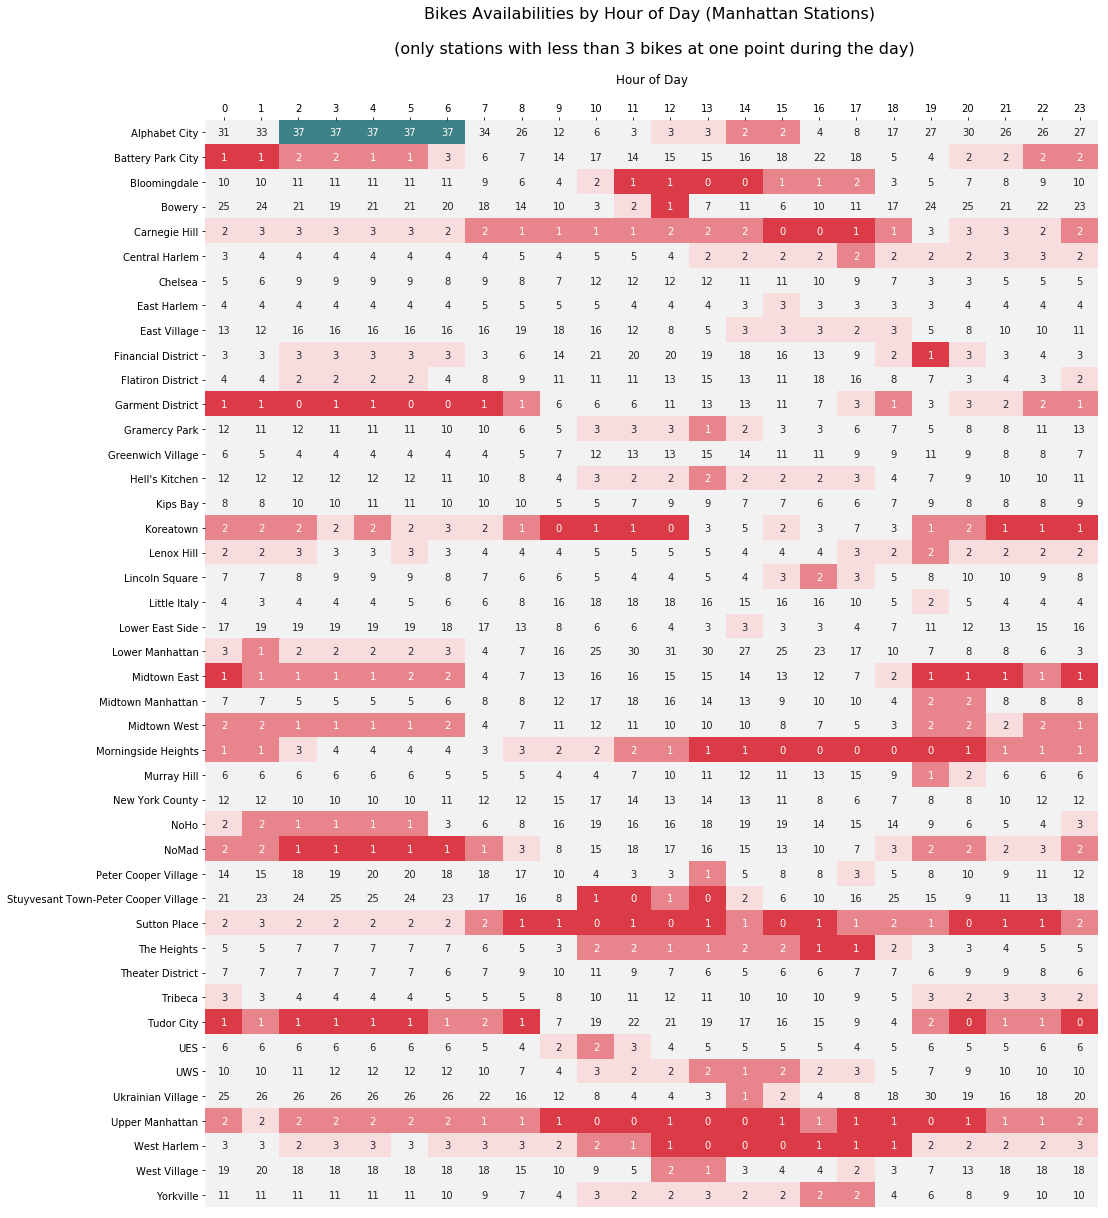

In [11]:
fig, ax = plt.subplots(figsize=(16,20))

cmap = sns.diverging_palette(10, 200, sep=225, n=40) 
sns.heatmap(data=df_pivot, cmap=cmap, annot=True, fmt=".0f", cbar_kws={"shrink": 0.7}, cbar= False)

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 20

plt.ylabel('')
plt.xlabel('Hour of Day', fontsize = 12)

plt.title('Bikes Availabilities by Hour of Day (Manhattan Stations) \n \n (only stations with less than 3 bikes at one point during the day)', pad=20, 
          fontsize=16);


##### At the station level?

### Additional Segmentation & Analysis

### Insights & Recommendations